In [18]:
! pip install fbprophet
! pip install googletrans==3.1.0a0

In [27]:
import googletrans
from googletrans import Translator
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
def get_data(country):
    apple_df=pd.read_csv('../data/applemobilitytrends-2021-04-26.csv')
    google_df=pd.read_csv('../data/Global_Mobility_Report.csv')
    df=pd.read_csv('../data/owid-covid-data.csv')
    df_lockdown=pd.read_excel('../data/Gov_Responses2Covid19_last.xlsx',sheet_name='Dataset')

    spain_apple_mob=apple_df[apple_df.region.isin(country)]
    spain_apple_mob=spain_apple_mob.drop(['geo_type','region','alternative_name','sub-region','country'],axis=1)
    spain_apple_mob=(spain_apple_mob.T).rename({123:'driving',124:'transit',125:'walking'},axis=1).drop(['transportation_type'],axis=0)

    spain_google_mob=google_df[google_df.country_region.isin(country)]
    spain_google_mob.drop(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
        'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'],axis=1,inplace=True)
    spain_google_mob=spain_google_mob.groupby('date').agg({'mean'})
    spain_google_mob.reset_index(inplace=True)

    covid_data=df[df.location.isin(country)]  
    covid_data.drop(['iso_code','continent'],axis=1,inplace=True)

    df_lockdown=df_lockdown[df_lockdown.country.isin(country)]
    df_lockdown.drop(['country','geoid','iso','continent'],axis=1,inplace=True)

    df_lockdown=df_lockdown.rename({'d':'date'},axis=1)
    df_lockdown['date']=pd.to_datetime(df_lockdown['date'])
    spain_google_mob['date']=pd.to_datetime(spain_google_mob['date'])
    spain_apple_mob=spain_apple_mob.reset_index().rename({'index':'date'},axis=1)
    spain_apple_mob['date']=pd.to_datetime(spain_apple_mob['date'])
    covid_data['date']=pd.to_datetime(covid_data['date'])

    df_final=covid_data.merge(spain_google_mob,on='date',how='left')
    df_final=df_final.merge(spain_apple_mob,on='date',how='left')
    df_final=df_final.merge(df_lockdown,on='date',how='left')

    return df_final


In [23]:
df_final=get_data(["Spain","Germany",'Italy','France'])

columns=['date','location','total_cases','new_cases','total_deaths','new_deaths','total_cases_per_million','new_cases_per_million','reproduction_rate',
      'new_tests_smoothed','positive_rate','tests_per_case','stringency_index','driving','walking','transit',('residential_percent_change_from_baseline', 'mean'),
      ('workplaces_percent_change_from_baseline', 'mean'),('transit_stations_percent_change_from_baseline', 'mean'),('parks_percent_change_from_baseline', 'mean',),
      ('grocery_and_pharmacy_percent_change_from_baseline', 'mean'),('retail_and_recreation_percent_change_from_baseline', 'mean'),'total_vaccinations',
      'people_vaccinated','people_fully_vaccinated','new_vaccinations']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [24]:
df_final.fillna(method='ffill',inplace=True)
df_clean=df_final[columns].fillna(0)
df_clean.columns=['date','country','total_cases','new_cases','total_deaths','new_deaths','total_cases_per_million','new_cases_per_million','reproduction_rate',
         'new_tests_smoothed','positive_rate','tests_per_case','stringency_index','driving','walking','transit','residential_percent_change_from_baseline',
         'workplaces_percent_change_from_baseline','transit_stations_percent_change_from_baseline','parks_percent_change_from_baseline',
         'grocery_and_pharmacy_percent_change_from_baseline','retail_and_recreation_percent_change_from_baseline','total_vaccinations',
         'people_vaccinated','people_fully_vaccinated','new_vaccinations']

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [25]:
df_clean=df_clean.drop_duplicates(subset=['date','country'])
df_clean=df_clean[df_clean.date>='2020-02-01']
df_grp=df_clean.groupby('country')

Plots

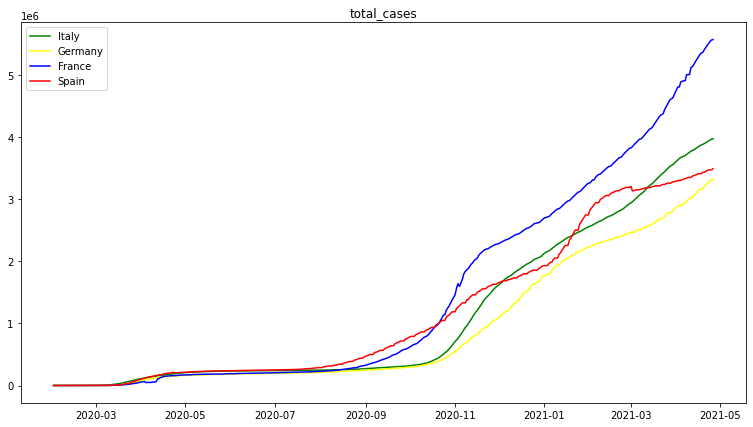

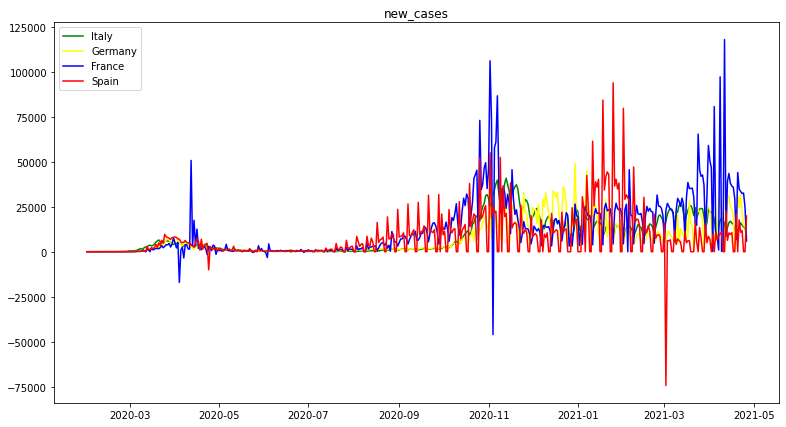

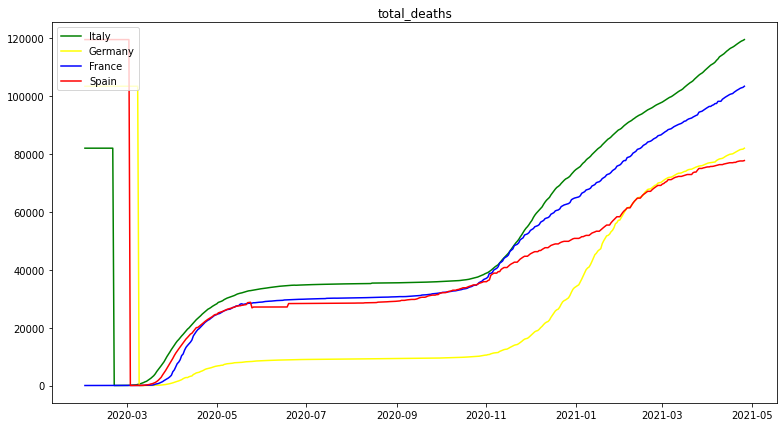

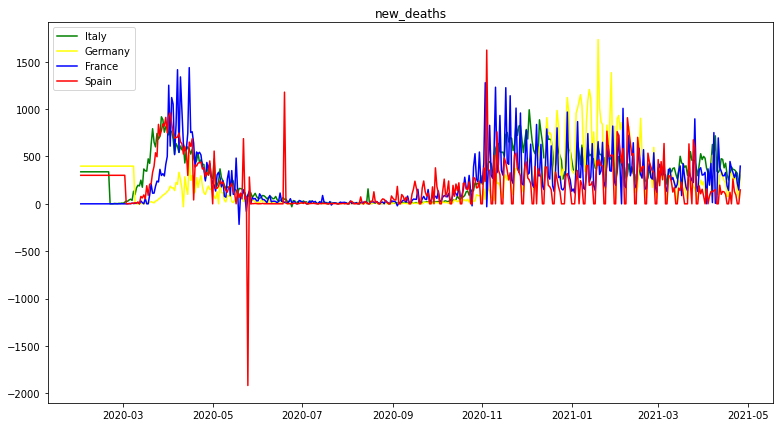

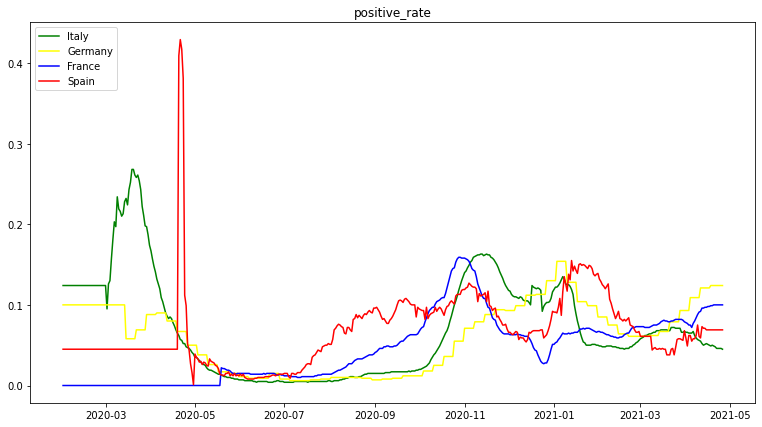

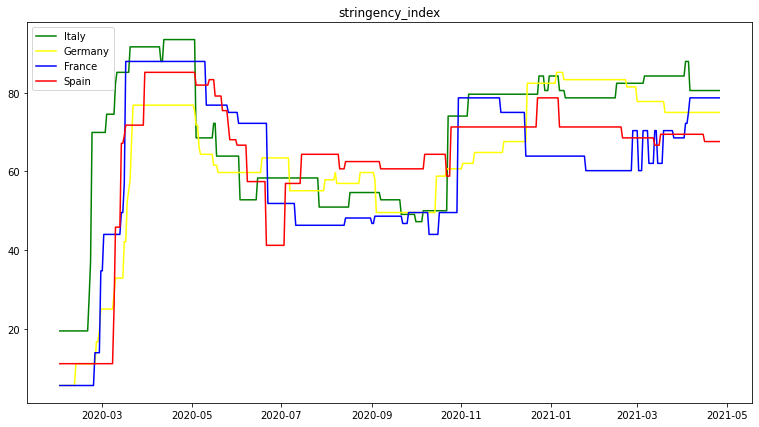

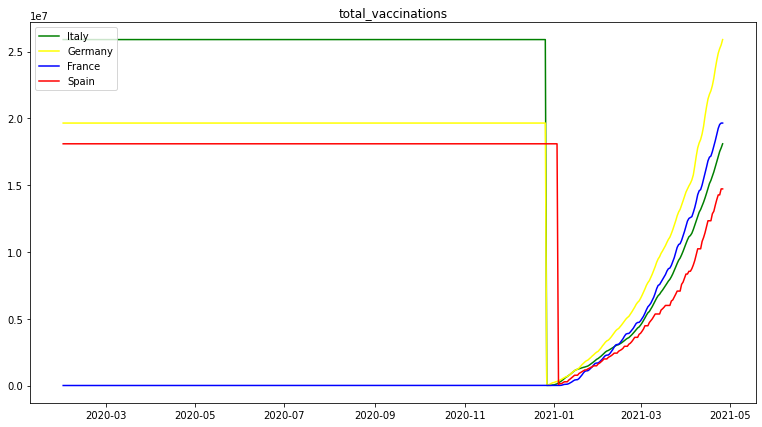

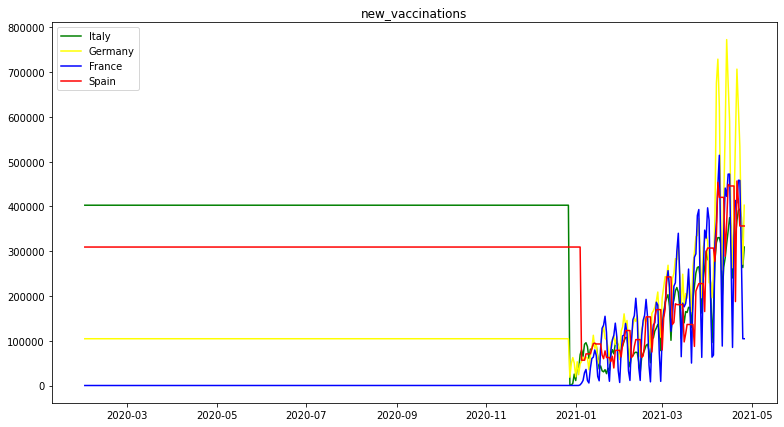

In [28]:
for i in df_clean.columns:
    if (i!='date' and i!='country' and i in ['total_cases','new_cases','total_deaths','new_deaths','positive_rate','stringency_index','total_vaccinations','new_vaccinations']):
        fig, ax = plt.subplots(figsize=(13,7))
        ax.plot(df_clean[df_clean.country=="Italy"]['date'],df_clean[df_clean.country=="Italy"][i],color = 'green', label = 'Italy')
        ax.plot(df_clean[df_clean.country=="Germany"]['date'],df_clean[df_clean.country=="Germany"][i],color = 'yellow', label = 'Germany')
        ax.plot(df_clean[df_clean.country=="France"]['date'],df_clean[df_clean.country=="France"][i],color = 'blue', label = 'France')
        ax.plot(df_clean[df_clean.country=="Spain"]['date'],df_clean[df_clean.country=="Spain"][i],color = 'red', label = 'Spain')
        ax.legend(loc = 'upper left')
        plt.title(i)
        plt.show


In [29]:
def apply_prophet(df, df_a, period,country,predict):
    m = Prophet()
    for clm in df:
    if clm != 'ds' and clm != 'y':
        m.add_regressor(clm)

    m.fit(df)
    future = m.make_future_dataframe(periods=period)

    future = pd.merge(future, df_a, on = 'ds')

    forecast = m.predict(future)
    fig = graph = m.plot(forecast)
    ax = fig.gca()
    ax.set_title(country)
    ax.set_xlabel("date")
    ax.set_ylabel(predict)
  

In [30]:
def get_df_final_prophet(country, predict):
    df = pd.read_csv("../data/owid-covid-data.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['location'] == country]
    df = df[df['date'] > pd.to_datetime('2020-03-01')]
    df = df[df['date'] < pd.to_datetime('2021-01-01')]
    df.fillna(method='ffill', inplace = True)
    df.fillna(0, inplace = True)
    df = df.drop([clm for clm in df if clm != 'date' and clm != predict and clm != 'new_tests_smoothed'], axis = 1)

    dd = pd.read_csv('/content/drive/MyDrive/ML_data/Global_Mobility_Report.csv')
    dd = dd[dd['country_region'] == country]
    for clm in dd:
    if clm == 'date':
        break
    else:
        dd.drop([clm], axis = 1, inplace = True)
    dd.fillna(method='ffill', inplace = True)
    dd.fillna(0, inplace = True)
    dd['date'] = pd.to_datetime(dd['date'])
    dd = dd.groupby('date', as_index=False).mean()
    df = pd.merge(df, dd, on = 'date')
    df = df.rename({'date' : 'ds', predict : 'y'}, axis = 1)

    for clm in df:
    if clm != 'new_tests_smoothed' and clm != 'ds' and clm != 'y':
        df[clm] = df[clm].rolling(window = 7).mean()
    df = df[df['ds'] > pd.to_datetime('2020-03-07')]

    return df

In [31]:
def get_df_a_prophet(country):
    df = pd.read_csv("../data/owid-covid-data.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['location'] == country]
    df = df[df['date'] > pd.to_datetime('2020-03-01')]
    df.fillna(method='ffill', inplace = True)
    df.fillna(0, inplace = True)
    df = df.drop([clm for clm in df if clm != 'date' and clm != 'new_tests_smoothed'], axis = 1)

    dd = pd.read_csv('/content/drive/MyDrive/ML_data/Global_Mobility_Report.csv')
    dd = dd[dd['country_region'] == country]
    for clm in dd:
    if clm == 'date':
        break
    else:
        dd.drop([clm], axis = 1, inplace = True)
    dd.fillna(method='ffill', inplace = True)
    dd.fillna(0, inplace = True)
    dd['date'] = pd.to_datetime(dd['date'])
    dd = dd.groupby('date', as_index=False).mean()
    df = pd.merge(df, dd, on = 'date')
    df = df.rename({'date' : 'ds'}, axis = 1) 

    for clm in df:
    if clm != 'new_tests_smoothed' and clm != 'ds':
        df[clm] = df[clm].rolling(window = 7).mean()
    df = df[df['ds'] > pd.to_datetime('2020-03-07')] 

    return df  

Total cases for Italy


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for France


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for Spain


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for Germany


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


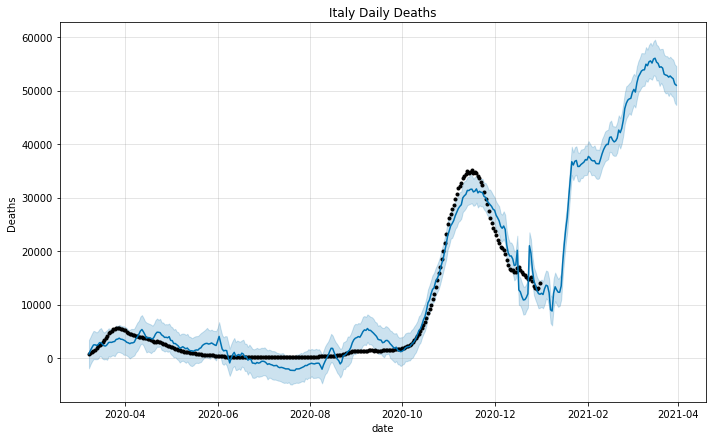

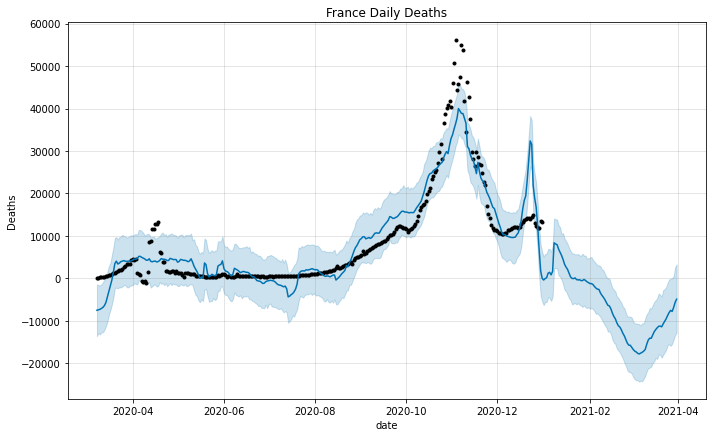

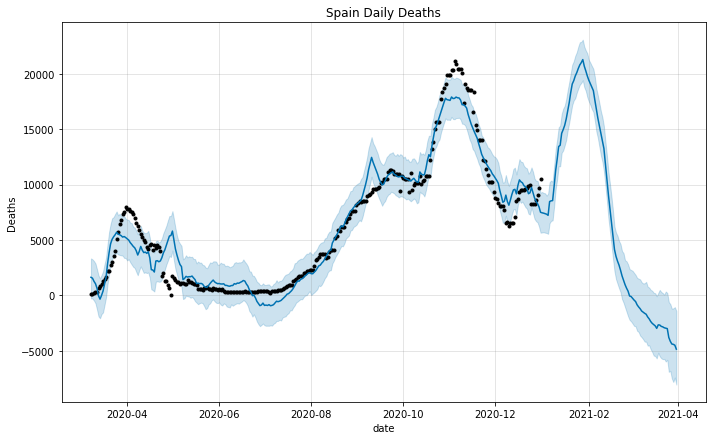

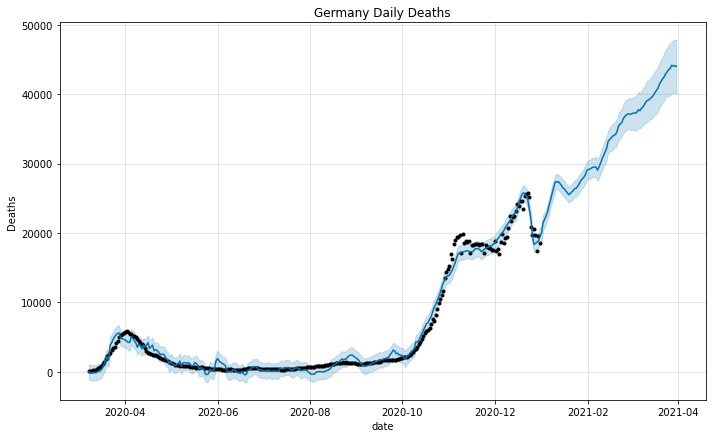

In [32]:
for i in ['Italy','France','Spain','Germany']:
    print("Total cases for",i)
    apply_prophet(get_df_final_prophet(i, 'new_cases_smoothed'), get_df_a_prophet(i), 90,i+" Daily Deaths","Deaths")

Total cases for Italy


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for France


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for Spain


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total cases for Germany


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


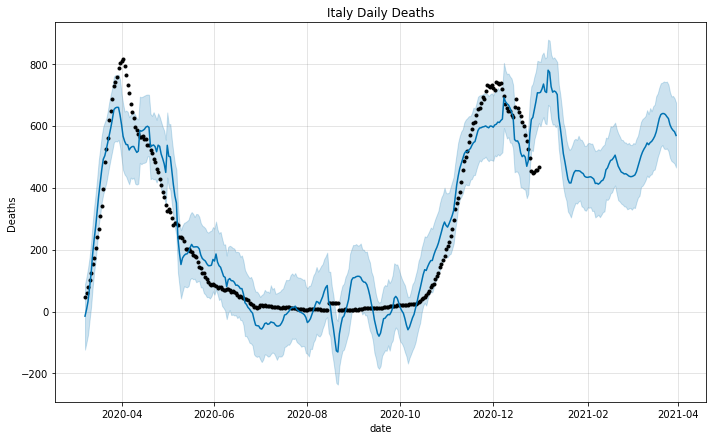

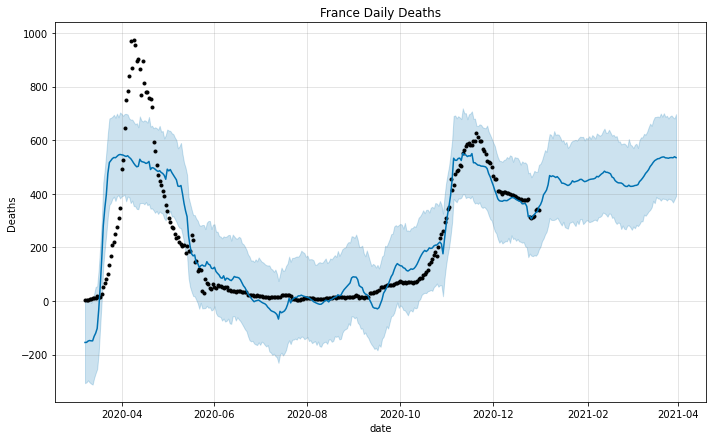

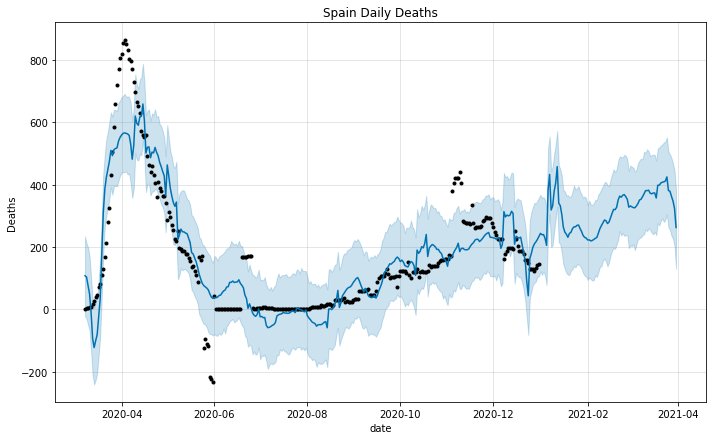

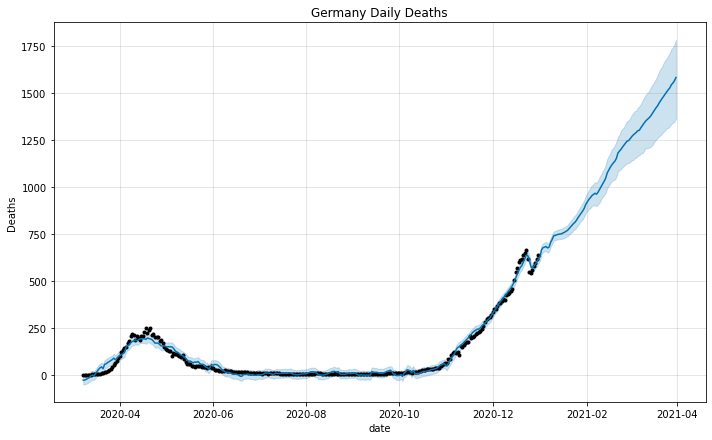

In [33]:
for i in ['Italy','France','Spain','Germany']:
    print("Total cases for",i)
    apply_prophet(get_df_final_prophet(i, 'new_deaths_smoothed'), get_df_a_prophet(i), 90,i+" Daily Deaths","Deaths")